In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 10})
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker

import pickle as pkl
from tqdm import tqdm

exec(open("./diagnostics_header.py").read())
import diagnostics_ops as diops
import diagnostics_vars as divars

# -----------------------------------------------------------------

# linestyles list from https://matplotlib.org/gallery/lines_bars_and_markers/linestyles.html
linestyles = [('solid',               (0, ())),
     #('loosely dotted',      (0, (1, 10))),
     #('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     #('loosely dashed',      (0, (5, 10))),
     #('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     #('loosely dashdotted',  (0, (3, 10, 1, 10))),
     #('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     #('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     #('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('solid',               (0, ()))]

In [2]:
save = False
dpi=300

Porb = 2.*np.pi

# start times of data used in plots
tstart_plot = {5.:(183.1000213623047/Porb), 10.:34.} #Porb

# time limits of accretion states
accretion_state_times = {5.:{}, 10.:{'A':[34.,39.], 'B':[39., 45.6]}}

# problem parameters
mach_nos = [5., 10.]
GM1 = 0.7692307692307692
x1min = 0.05
x1max = 0.62              # maximum value of X1
inflow = -0.01            # radial velocity at L1
inflow_dens = {5.:1.0, 10.:4.0}         # density at L1
inflow_phi = {5.:0.1, 10.:0.05}         # angular half-size of the L1 zone
                          # if -n, L1 diameter set to n times thermal scale height
vel_ceil = 0.5
dfloor = 1.0e-6

inflow_mdot = {}
for mach_no in mach_nos:
    inflow_mdot[mach_no] = - np.pi * (x1max*inflow_phi[mach_no])**2 * inflow_dens[mach_no] * inflow
    print('Inflow mdot for M%i: %.2e' % (int(mach_no), inflow_mdot[mach_no]))

# maximum possible mdot from the floor at the outer edge of the grid
def floor_mdot (r):
     return 4.*np.pi*r**2 * vel_ceil * dfloor

print('Maximum floor mdot: %.2e' % floor_mdot(0.5))

Inflow mdot for M5: 1.21e-04
Inflow mdot for M10: 1.21e-04
Maximum floor mdot: 1.57e-06


In [3]:
dataset_pathstem = {5.:'/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M5/R4_32_dfloor1e-6_vfloorRho1e-5/', 10.:'/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M10_noInfl/R5_4b_lowDfloor/R5_dfloor1e-6_vfloorRho1e-5/'}

snapshots = {5.:{None:'snapshots/mhdLoops_strat.out2.02308.athdf'}, 10.:{None:'snapshots/mhdLoops_strat.out2.00908.athdf', 'A':'snapshots/mhdLoops_strat.out2.00775.athdf', 'B':'snapshots/mhdLoops_strat.out2.00908.athdf'}}

output_path = '/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/Paper1/figures/toSend/Paper1/'

In [9]:

# PLOT 1: ACCRETION RATES, time variability

noFloor = False
if noFloor:
    TSeries_name = 'TSeries_noFloor.pkl'
else:
    TSeries_name = 'TSeries.pkl'

mdot_unit = 1.0e-4

plot_linewidth = 1.25

def rad2color (radius):
    if radius < 0.3:
        if np.abs(radius-0.18) > 0.01:
            return cm.coolwarm(1.0-(radius-0.08)/(0.3-0.08))
        else:
            return 'grey'
    else:
        return cm.RdBu(1.0)

fig = plt.figure(figsize=(7.,6.))
gs = gridspec.GridSpec(2,2, hspace=0.1, wspace=0.1)

plot_radii_rho = np.array([0.08, 0.10, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3, 0.5])
plot_radii_mdot = np.array([0.08, 0.10, 0.15, 0.21, 0.27, 0.5])

# ________________________________________

# MACH 5
mach_no = 5.
if noFloor:
    frames_to_avg = int(max(1, int(2.*np.pi)))
else:
    frames_to_avg = int(max(1, int(2.*np.pi/0.1)))

#-----------------------------------------

# mdot through radius
plt.subplot(gs[1,0])
with open(dataset_pathstem[mach_no] + TSeries_name, 'rb') as f:
    tseries = pkl.load(f)

for radius in list(plot_radii_mdot[:-1][::-1]) + [0.5,]:
    # convert to pandas, calculate rolling means
    df = pd.DataFrame.from_dict(tseries['mdot'][radius])
    df[['t_boxcar','val_boxcar']] = df.rolling(frames_to_avg, center=True, win_type='boxcar').mean()
    #df['sd_boxcar'] = df.val.rolling(frames_to_avg, center=True).std()

    plt.plot(df.t_boxcar/(2.*np.pi) - tstart_plot[mach_no], df.val_boxcar/mdot_unit, label=('r=%.2f' % radius), color=rad2color(radius),
             #linestyle=linestyles[i][1], #color-blind friendly
             lw=plot_linewidth)
    if False:# not noFloor:
        plt.axhline(floor_mdot(radius)/mdot_unit, color=rad2color(radius), ls=':')
    #plt.fill_between(df.t_boxcar, df.val_boxcar-df.sd_boxcar, df.val_boxcar + df.sd_boxcar, color='grey', alpha=0.2)
#plt.axhline(inflow_mdot[mach_no]/mdot_unit, color='k', ls='-', lw=2, label='Inflow')
    
plt.axhline(0.0, color='k', linewidth=1., ls='-')

#plt.semilogy()
plt.grid()
plt.xlabel('Time [$P_{orb}$]')
plt.ylabel('$\dot{M}(r)$ [$10^{-4}$ sim.u.]')
plt.xlim(0., 8.89675791892056)
#plt.ylim(0., 4.0)

#-----------------------------------------

# rho at radius
plt.subplot(gs[0,0])
with open(dataset_pathstem[mach_no] + 'Rho_Bmag_profiles1D.pkl', 'rb') as f:
    profiles1D = pkl.load(f)

times = np.array([x[0] for x in profiles1D])
radii = profiles1D[0][1]['rho']['r']['r']
rho = np.array([x[1]['rho']['r']['val'] for x in profiles1D])

# figure out indices to show
ridxs = [max(np.where(radii < radius)[0]) for radius in plot_radii_rho]

for ridx in ridxs:
    radius = radii[ridx]
    plt.plot(times/(2.*np.pi) - tstart_plot[mach_no], rho[:,ridx], color=rad2color(radius), label=('$r=%.2f$' % radius), lw=plot_linewidth)
#plt.xlabel('Time [$P_{\\rm orb}$]')
plt.setp( plt.gca().get_xticklabels(), visible=False)
plt.ylabel('$\\rho(r)$ [sim.u.]')
plt.xlim(0., 8.89675791892056)
#plt.semilogy()
plt.grid(True)

plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(-0.15, 1.3))

# ________________________________________

# MACH 10
mach_no = 10.
frames_to_avg = int(2.*max(1, int(2.*np.pi/0.3)))

#-----------------------------------------

# mdot through radius
plt.subplot(gs[1,1])

with open(dataset_pathstem[mach_no] + TSeries_name, 'rb') as f:
    tseries = pkl.load(f)
    
for radius in list(plot_radii_mdot[:-1][::-1]) + [0.5,]: #list(reversed(list(tseries['mdot'].keys())[2:-1]))+[0.5,]:
    # convert to pandas, calculate rolling means
    df = pd.DataFrame.from_dict(tseries['mdot'][radius])
    df[['t_boxcar','val_boxcar']] = df.rolling(frames_to_avg, center=True, win_type='boxcar').mean()
    #df['sd_boxcar'] = df.val.rolling(frames_to_avg, center=True).std()

    plt.plot(df.t_boxcar/(2.*np.pi) - tstart_plot[mach_no], df.val_boxcar/mdot_unit, label=('r=%.2f' % radius), color=rad2color(radius),
             #linestyle=linestyles[i][1], #color-blind friendly
             lw=plot_linewidth)
    if False:# not noFloor:
        plt.axhline(floor_mdot(radius)/mdot_unit, color=rad2color(radius), ls=':')
    #plt.fill_between(df.t_boxcar, df.val_boxcar-df.sd_boxcar, df.val_boxcar + df.sd_boxcar, color='grey', alpha=0.2)
    
plt.axhline(0.0, color='k', linewidth=1., ls='-')
    
# add boundaries of accretion states
if False:
    for key in accretion_state_times[mach_no]:
        t1,t2 = accretion_state_times[mach_no][key]
        plt.axvline(t1-tstart_plot[mach_no], color='k', ls=':', lw=2)
        plt.axvline(t2-tstart_plot[mach_no], color='k', ls=':', lw=2)
        plt.text(0.5*(t1+t2)-0.25-tstart_plot[mach_no], 2.25, key) #-1.3

#plt.legend(ncol=3, loc='upper left')
plt.grid()
plt.xlim(0.,45.6-tstart_plot[mach_no])
#plt.ylim(0., 4.0)
plt.xlabel('Time [$P_{orb}$]')
plt.ylabel('$\dot{M}(r)$ [$10^{-4}$ sim.u.]')
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

#-----------------------------------------

# rho at radius
plt.subplot(gs[0,1])
with open(dataset_pathstem[mach_no] + 'Rho_Bmag_profiles1D.pkl', 'rb') as f:
    profiles1D = pkl.load(f)

times = np.array([x[0] for x in profiles1D])
radii = profiles1D[0][1]['rho']['r']['r']
rho = np.array([x[1]['rho']['r']['val'] for x in profiles1D])

# figure out indices to show
#plot_radii = sorted(list(tseries['mdot'].keys())[:-1])[1:]
ridxs = [max(np.where(radii <= radius)[0]) for radius in plot_radii_rho]

for ridx in ridxs:
    radius = radii[ridx]
    if ('%.2f' % radii[ridx]) in ['0.20', '0.30']: continue
    plt.plot(times/(2.*np.pi) - tstart_plot[mach_no], rho[:,ridx], color=rad2color(radius), label=('$r=%.2f$' % radius), lw=plot_linewidth)
plt.xlim(0.,45.6-tstart_plot[mach_no])
#plt.legend(ncol=1)
#plt.xlabel('Time [$P_{\\rm orb}$]')
plt.ylabel('$\\rho(r)$ [sim.u.]')
plt.grid(True)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.setp( plt.gca().get_xticklabels(), visible=False)
    
# add boundaries of accretion states
for key in accretion_state_times[mach_no]:
    t1,t2 = accretion_state_times[mach_no][key]
    plt.axvline(t1-tstart_plot[mach_no], color='k', ls=':', lw=2)
    plt.axvline(t2-tstart_plot[mach_no], color='k', ls=':', lw=2)
    plt.text(0.5*(t1+t2)-0.25-tstart_plot[mach_no], 0.1, key)

#plt.legend(ncol=3, loc='upper left', bbox_to_anchor=(-0.05, 1.3))

# ________________________________________

plt.subplots_adjust(right=0.87)

#plt.tight_layout()
if True:
    plt.savefig(output_path + 'mdot.png', format='png', dpi=dpi)
else:
    plt.show()
plt.close()

In [ ]:

# PLOT 2a: Density snapshots

#for colormap in ['rainbow', 'jet', 'gnuplot', 'PiYG', 'Spectral', 'YlOrBr']:
colormap = 'Spectral_r' # 'Spectral'

plt.rcParams.update({'font.size': 10})
if save:
    fig = plt.figure(figsize=(7.,4.5))
else:
    fig = plt.figure(figsize=(14.,9.))
gs = gridspec.GridSpec(2,4, width_ratios=[0.05,1.,1.,0.05])
vars_obj = divars.Default('rho')

times = {}
rmin = {}

# MACH 5

mach_no = 5.
snapshot_path = dataset_pathstem[mach_no] + snapshots[mach_no][None]

kwargs_common = {'log_scale':True, 'vmin':1.0e-5, 'vmax':1.0, 'levels':50, 'kwargs':{'cmap':colormap}}

ops_obj = diops.EquatorialSlice(vars_obj)
ops_obj.read(snapshot_path)
times[mach_no] = ops_obj.time/Porb - tstart_plot[mach_no]
rmin[mach_no] = min(ops_obj.r)
ax, plot = ops_obj.plot(fig, subplot_spec=gs[0,1], **kwargs_common)
ax.set_ylim(0., None)
ax.set_yticks([0.1, 0.3, 0.5])
ax.set_yticklabels([0.1, 0.3, 0.5])
del ops_obj

ops_obj = diops.PoloidalSlice(vars_obj, x1max=0.4)
ops_obj.read(snapshot_path)
ax, plot = ops_obj.plot(fig, subplot_spec=gs[1,:2], plot_type='box', **kwargs_common)
del ops_obj
ops_obj = diops.PoloidalSlice(vars_obj, intersect=np.pi, x1max=0.4)
ops_obj.read(snapshot_path)
ax, plot = ops_obj.plot(fig, subplot_spec=gs[1,:2], plot_type='box', **kwargs_common, flip=True, rticks=[0.1, 0.2, 0.3])
ax.set_xlim(-0.35,0.35)
ax.set_ylim(-0.175,0.175)
del ops_obj

# add lines for disk body and corona
for angle in [0., 2.5/mach_no, 5./mach_no]:
    xx = np.linspace(-0.35,-np.cos(angle)*rmin[mach_no])
    yy = - np.tan(angle)*xx
    plt.plot(xx, yy, 'k-', linewidth=1.)

plt.subplot(gs[0,0])
cbar = fig.colorbar(plot, plt.gca(), orientation='vertical',
            ticks=[-5,-3,-1,0])
cbar.ax.set_yticklabels(['$10^{-5}$', '$10^{-3}$', '$0.1$', '1'])

#-----------------------------------------
# MACH 10

mach_no = 10.
snapshot_path = dataset_pathstem[mach_no] + snapshots[mach_no][None]

kwargs_common = {'log_scale':True, 'vmin':1.0e-5, 'vmax':5.0, 'levels':50, 'kwargs':{'cmap':colormap}}

ops_obj = diops.EquatorialSlice(vars_obj)
ops_obj.read(snapshot_path)
times[mach_no] = ops_obj.time/Porb - tstart_plot[mach_no]
rmin[mach_no] = min(ops_obj.r)
ax, plot = ops_obj.plot(fig, subplot_spec=gs[0,2], **kwargs_common)
ax.set_ylim(0., None)
ax.set_yticks([0.1, 0.3, 0.5])
ax.set_yticklabels([0.1, 0.3, 0.5])
del ops_obj

gs2 = gs[1,2:].subgridspec(1,2,wspace=0.)

ops_obj = diops.PoloidalSlice(vars_obj, intersect=np.pi, x1max=0.4)
ops_obj.read(snapshot_path)
ax, plot = ops_obj.plot(fig, subplot_spec=gs2[0,0], plot_type='box', rticks=[0.1, 0.2, 0.3], **kwargs_common, flip=True)
ax.set_xlim(-0.35,0.)
ax.set_ylim(-0.175,0.175)
del ops_obj

# add lines for disk body and corona
for angle in [0., 2./mach_no, 10./mach_no]:
    xx = np.linspace(-0.35,-np.cos(angle)*rmin[mach_no])
    yy = - np.tan(angle)*xx
    plt.plot(xx, yy, 'k-', linewidth=1.)

ops_obj = diops.PoloidalSlice(vars_obj, x1max=0.2)
ops_obj.read(snapshot_path)
ax, plot = ops_obj.plot(fig, subplot_spec=gs2[0,1], plot_type='box', rticks=[0.05, 0.10, 0.15], tick_ang=(-0.125*np.pi), **kwargs_common)
ax.set_xlim(0.04,0.16)
ax.set_ylim(-0.175*0.12/0.35,0.175*0.12/0.35)
del ops_obj

plt.subplot(gs[0,3])
cbar = fig.colorbar(plot, plt.gca(), orientation='vertical',
            ticks=[-5,-3,-1,np.log10(5.)])
cbar.ax.set_yticklabels(['$10^{-5}$', '$10^{-3}$', '$0.1$', '5'])

#-----------------------------------------

#plt.suptitle('Density')
plt.subplot(gs[1,:2])
plt.title('Mach 5, $t=%.1fP_{\\rm orb}$' % (times[5.],))
plt.subplot(gs2[0,0])
plt.title('Mach 10, $t=%.1fP_{\\rm orb}$' % (times[10.],))
plt.subplot(gs2[0,1])
plt.title('zoom-in')

if save:
    plt.tight_layout()
    plt.savefig(output_path + 'snapshot_rho.png', format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

In [ ]:

# PLOT 2b: Plasma beta snapshots

plt.rcParams.update({'font.size': 10})
if save:
    fig = plt.figure(figsize=(7.,4.5))
else:
    fig = plt.figure(figsize=(14.,9.))
gs = gridspec.GridSpec(2,4, width_ratios=[0.05,1.,1.,0.05])
vars_obj = divars.PlasmaBeta()

times = {}
rmin = {}

# MACH 5

mach_no = 5.
snapshot_path = dataset_pathstem[mach_no] + snapshots[mach_no][None]

kwargs_common = {'log_scale':True, 'vmin':1.0e-1, 'vmax':3.0e4, 'levels':50, 'kwargs':{'cmap':'jet'}}
tick_ang = 1.125*np.pi

ops_obj = diops.EquatorialSlice(vars_obj)
ops_obj.read(snapshot_path)
times[mach_no] = ops_obj.time/Porb - tstart_plot[mach_no]
rmin[mach_no] = min(ops_obj.r)
ax, plot = ops_obj.plot(fig, subplot_spec=gs[0,1], **kwargs_common)
ax.set_ylim(0., None)
tticks = [0.3, 0.5]
ax.set_yticks(tticks)
ax.set_yticklabels([])
for tt in tticks:
    ax.text(tick_ang, tt+0.035, tt, color='k', bbox=dict(boxstyle='square', ec='k', fc='white'))
ax.grid(color='k', linewidth=0.5)
del ops_obj

ops_obj = diops.PoloidalSlice(vars_obj, intersect=np.pi, x1max=0.4)
ops_obj.read(snapshot_path)
ax, plot = ops_obj.plot(fig, subplot_spec=gs[1,:2], plot_type='box', **kwargs_common, flip=True, rticks=[0.1, 0.2, 0.3], tick_linecolor='k', tick_box=True)
del ops_obj
ops_obj = diops.PoloidalSlice(vars_obj, x1max=0.4)
ops_obj.read(snapshot_path)
ax, plot = ops_obj.plot(fig, subplot_spec=gs[1,:2], plot_type='box', **kwargs_common)
del ops_obj
ax.set_xlim(-0.35,0.35)
ax.set_ylim(-0.175,0.175)

# add lines for disk body and corona
for angle in [0., 2.5/mach_no, 5./mach_no]:
    xx = np.linspace(-0.35,-np.cos(angle)*rmin[mach_no])
    yy = np.tan(angle)*xx
    plt.plot(xx, yy, 'k-', linewidth=2.)

plt.subplot(gs[0,0])
cbar = fig.colorbar(plot, plt.gca(), orientation='vertical',
            ticks=[-1, 0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(['$0.1$', '1', '10', '$10^{2}$', '$10^{3}$', '$10^{4}$'])

#-----------------------------------------
# MACH 10

mach_no = 10.
snapshot_path = dataset_pathstem[mach_no] + snapshots[mach_no][None]

kwargs_common = {'log_scale':True, 'vmin':1.0e-1, 'vmax':3.0e4, 'levels':50, 'kwargs':{'cmap':'jet'}}

ops_obj = diops.EquatorialSlice(vars_obj)
ops_obj.read(snapshot_path)
times[mach_no] = ops_obj.time/Porb - tstart_plot[mach_no]
rmin[mach_no] = min(ops_obj.r)
ax, plot = ops_obj.plot(fig, subplot_spec=gs[0,2], **kwargs_common)
ax.set_ylim(0., None)
tticks = [0.3, 0.5]
ax.set_yticks(tticks)
ax.set_yticklabels([])
for tt in tticks:
    ax.text(tick_ang, tt+0.035, tt, color='k', bbox=dict(boxstyle='square', ec='k', fc='white'))
ax.grid(color='k', linewidth=0.5)
del ops_obj

gs2 = gs[1,2:].subgridspec(1,2,wspace=0.)

ops_obj = diops.PoloidalSlice(vars_obj, intersect=np.pi, x1max=0.4)
ops_obj.read(snapshot_path)
ax, plot = ops_obj.plot(fig, subplot_spec=gs2[0,0], plot_type='box', rticks=[0.1, 0.2, 0.3], tick_box=True, tick_linecolor='k', **kwargs_common, flip=True)
ax.set_xlim(-0.35,0.)
ax.set_ylim(-0.175,0.175)
del ops_obj

# add lines for disk body and corona
for angle in [0., 2./mach_no, 10./mach_no]:
    xx = np.linspace(-0.35,-np.cos(angle)*rmin[mach_no])
    yy = np.tan(angle)*xx
    plt.plot(xx, yy, 'k-', linewidth=2.)
    
ops_obj = diops.PoloidalSlice(vars_obj, x1max=0.2)
ops_obj.read(snapshot_path)
ax, plot = ops_obj.plot(fig, subplot_spec=gs2[0,1], plot_type='box', rticks=[0.05, 0.10, 0.15], tick_ang=(-0.125*np.pi), tick_box=True, tick_linecolor='k', **kwargs_common)
ax.set_xlim(0.04,0.16)
ax.set_ylim(-0.175*0.12/0.35,0.175*0.12/0.35)
del ops_obj

plt.subplot(gs[0,3])
cbar = fig.colorbar(plot, plt.gca(), orientation='vertical',
            ticks=[-1, 0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(['$0.1$', '1', '10', '$10^{2}$', '$10^{3}$', '$10^{4}$'])

#-----------------------------------------

plt.subplot(gs[1,:2])
plt.title('Mach 5, $t=%.1fP_{\\rm orb}$' % (times[5.],))
plt.subplot(gs2[0,0])
plt.title('Mach 10, $t=%.1fP_{\\rm orb}$' % (times[10.],))
plt.subplot(gs2[0,1])
plt.title('zoom-in')

if save:
    plt.tight_layout()
    plt.savefig(output_path + 'snapshot_beta.png', format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

In [ ]:
from importlib import reload
reload(diops)

In [ ]:

# PLOT 3a: M5 vertical profiles

mach_no = 5.
stress_unit=1.0e-4
mdot_unit = 1.0e-5

def rad2color (radius):
    if radius != 0.15:
        return cm.RdBu((radius-0.06)/(0.25-0.06))
    else:
        return 'grey'

plt.rcParams.update({'font.size': 10})

# load and reuse
with open(dataset_pathstem[mach_no] + 'steady_vertical.pkl', 'rb') as f:
    ops_objs_vertical = pkl.load(f)
    
# plot
lss = {'slice':':', 'avg':'-'}

fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(4,2, wspace=0.1, hspace=0.25)

# Density
for t in ['avg',]:
    ax, plot = ops_objs_vertical['rho'][t].plot(fig, subplot_spec=gs[0,0], log_scale=True, color_fun=rad2color, kwargs={'ls':lss[t]})
plt.grid(True)
plt.title('Density [sim.u.]')

# Total pressure
for t in ['avg',]:
    ax, plot = ops_objs_vertical['Ptot'][t].plot(fig, subplot_spec=gs[0,1], log_scale=True, color_fun=rad2color, kwargs={'ls':lss[t]})
plt.grid(True)
plt.title('Total pressure [sim.u.]')

# Gas pressure
for t in ['avg',]:
    ax, plot = ops_objs_vertical['press'][t].plot(fig, subplot_spec=gs[1,0], log_scale=True, color_fun=rad2color, kwargs={'ls':lss[t]})
plt.grid(True)
plt.title('Gas pressure [sim.u.]')

# Magnetic pressure
for t in ['avg',]:
    ax, plot = ops_objs_vertical['Pmag'][t].plot(fig, subplot_spec=gs[1,1], log_scale=True, color_fun=rad2color, kwargs={'ls':lss[t]})
plt.grid(True)
plt.title('Magnetic pressure [sim.u.]')

# d mdot / dz
for t in ['avg',]:
    # divide by dz
    for rr in ops_objs_vertical['MdotVert'][t].radii:
        z = ops_objs_vertical['MdotVert'][t].z_over_r * rr
        z = np.insert(z, 0, z[0]) # for the right dims
        dz = z[1:] - z[:-1]
        ops_objs_vertical['MdotVert'][t].val[rr] = np.squeeze(ops_objs_vertical['MdotVert'][t].val[rr]) / dz
    #plot
    ax, plot = ops_objs_vertical['MdotVert'][t].plot(fig, subplot_spec=gs[2,0], log_scale=False, color_fun=rad2color, kwargs={'ls':lss[t]}, yunit=mdot_unit)
plt.grid(True)
plt.title('$d\dot{M}/dz$ [$10^{-5}$ sim.u.]')

# plasma beta
for t in ['avg',]:
    radii = ops_objs_vertical['press'][t].radii
    rmin, rmax = min(radii), max(radii)
    for r in radii:
        Pgas = ops_objs_vertical['press'][t].val[r]
        Pmag = ops_objs_vertical['Pmag'][t].val[r]
        plt.subplot(gs[2,1])
        plt.plot(ops_objs_vertical['press'][t].z_over_r ,Pgas/Pmag, color=rad2color(r), label=('$r=%.2f$' % r))
        plt.grid(True)
        plt.title('Plasma $\\beta$')
        plt.semilogy()

# stress_R
for t in ['avg',]:
    ax, plot = ops_objs_vertical['T_Reynolds'][t].plot(fig, subplot_spec=gs[3,0], log_scale=False, color_fun=rad2color, kwargs={'ls':lss[t]}, yunit=stress_unit)
plt.grid(True)
plt.title('Reynolds $r\phi$ stress [$10^{-4}$ sim.u.]')
plt.xlabel('$z/r$')

# stress_M
for t in ['avg',]:
    ax, plot = ops_objs_vertical['T_Maxwell'][t].plot(fig, subplot_spec=gs[3,1], log_scale=False, color_fun=rad2color, legend=False, kwargs={'ls':lss[t]}, yunit=stress_unit)
plt.grid(True)
plt.title('Maxwell $r\phi$ stress [$10^{-4}$ sim.u.]')
plt.xlabel('$z/r$')

# ----------------------------------------

for row in range(3):
    for col in range(2):
        plt.subplot(gs[row,col])
        plt.setp( plt.gca().get_xticklabels(), visible=False)
        plt.xlabel('')
for row in range(4):
    plt.subplot(gs[row,1])
    plt.gca().yaxis.tick_right()
    
plt.subplot(gs[3,0])
plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(-0.15, -0.35))

# ________________________________________

plt.subplots_adjust(top=0.95)

#plt.tight_layout()
if save:
    plt.savefig((output_path + 'vertical_M%i.png') % mach_no, format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

In [ ]:

# PLOT 3b: M10 vertical profiles

mach_no = 10.
stress_unit=1.0e-4
mdot_unit = 1.0e-5

plt.rcParams.update({'font.size': 10})

def rad2color (radius):
    if radius != 0.15:
        return cm.RdBu((radius-0.06)/(0.25-0.06))
    else:
        return 'grey'

# load and reuse
with open(dataset_pathstem[mach_no] + 'steady_vertical.pkl', 'rb') as f:
    ops_objs_vertical = pkl.load(f)
    
# plot
lss = {'slice':':', 'avg':'-'}

fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(4,2, wspace=0.1, hspace=0.25)

# Density
for t in ['avg',]:
    ax, plot = ops_objs_vertical['rho'][t].plot(fig, subplot_spec=gs[0,0], log_scale=True, color_fun=rad2color, kwargs={'ls':lss[t]})
plt.grid(True)
plt.title('Density [sim.u.]')

# Total pressure
for t in ['avg',]:
    ax, plot = ops_objs_vertical['Ptot'][t].plot(fig, subplot_spec=gs[0,1], log_scale=True, color_fun=rad2color, kwargs={'ls':lss[t]})
plt.grid(True)
plt.title('Total pressure [sim.u.]')

# Gas pressure
for t in ['avg',]:
    ax, plot = ops_objs_vertical['press'][t].plot(fig, subplot_spec=gs[1,0], log_scale=True, color_fun=rad2color, kwargs={'ls':lss[t]})
plt.grid(True)
plt.title('Gas pressure [sim.u.]')

# Magnetic pressure
for t in ['avg',]:
    ax, plot = ops_objs_vertical['Pmag'][t].plot(fig, subplot_spec=gs[1,1], log_scale=True, color_fun=rad2color, kwargs={'ls':lss[t]})
plt.grid(True)
plt.title('Magnetic pressure [sim.u.]')
plt.ylim(1.0e-8, None)

# d mdot / dz
for t in ['avg',]:
    # divide by dz
    for rr in ops_objs_vertical['MdotVert'][t].radii:
        z = ops_objs_vertical['MdotVert'][t].z_over_r * rr
        z = np.insert(z, 0, z[0]) # for the right dims
        dz = z[1:] - z[:-1]
        ops_objs_vertical['MdotVert'][t].val[rr] = np.squeeze(ops_objs_vertical['MdotVert'][t].val[rr]) / dz
    #plot
    ax, plot = ops_objs_vertical['MdotVert'][t].plot(fig, subplot_spec=gs[2,0], log_scale=False, color_fun=rad2color, kwargs={'ls':lss[t]}, yunit=mdot_unit)
plt.grid(True)
plt.title('$d\dot{M}/dz$ [$10^{-5}$ sim.u.]')

# plasma beta
for t in ['avg',]:
    radii = ops_objs_vertical['press'][t].radii
    rmin, rmax = min(radii), max(radii)
    for r in radii:
        Pgas = ops_objs_vertical['press'][t].val[r]
        Pmag = ops_objs_vertical['Pmag'][t].val[r]
        plt.subplot(gs[2,1])
        plt.plot(ops_objs_vertical['press'][t].z_over_r ,Pgas/Pmag, color=rad2color(r), label=('$r=%.2f$' % r))
        plt.grid(True)
        plt.title('$\\beta$')
        plt.semilogy()
#plt.ylim(1., 300.)

# stress_R
for t in ['avg',]:
    ax, plot = ops_objs_vertical['T_Reynolds'][t].plot(fig, subplot_spec=gs[3,0], log_scale=False, color_fun=rad2color, kwargs={'ls':lss[t]}, yunit=stress_unit)
plt.grid(True)
plt.title('Reynolds $r\phi$ stress [$10^{-4}$ sim.u.]')
plt.xlabel('$z/r$')

# stress_M
for t in ['avg',]:
    ax, plot = ops_objs_vertical['T_Maxwell'][t].plot(fig, subplot_spec=gs[3,1], log_scale=False, color_fun=rad2color, legend=False, kwargs={'ls':lss[t]}, yunit=stress_unit)
plt.grid(True)
plt.title('Maxwell $r\phi$ stress [$10^{-4}$ sim.u.]')
plt.xlabel('$z/r$')
#plt.ylim(-0.001/stress_unit, None)

# ----------------------------------------

for row in range(3):
    for col in range(2):
        plt.subplot(gs[row,col])
        plt.setp( plt.gca().get_xticklabels(), visible=False)
        plt.xlabel('')
for row in range(4):
    plt.subplot(gs[row,1])
    plt.gca().yaxis.tick_right()
    
plt.subplot(gs[3,0])
plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(-0.15, -0.35))

# ________________________________________

plt.subplots_adjust(top=0.95)

#plt.tight_layout()
if save:
    plt.savefig((output_path + 'vertical_M%i.png') % mach_no, format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

In [ ]:

# PLOT 4: spiral structure

rho_cmap = 'Spectral_r'

# pitch angle from the dispersion relation
def omega_binary ():
    return 1.0

def omega_keplerian (r, phi=0):
    return np.sqrt(GM1)/r**1.5

def tan_pitch (local_mach_no, omega_pattern, omega, m=2):
    return 1. / (local_mach_no * np.sqrt((1.-omega_pattern/omega)**2 - 1./m**2))

def csound_locIsoth (r, phi=0, mach_no=mach_no):
    return (np.sqrt(GM1/x1min) / mach_no) * (x1min/r)**(3./8.)

def mach_locIsoth (r, phi=0, mach_no=mach_no):
    return np.sqrt(GM1/r) / csound_locIsoth(r, mach_no=mach_no)

steps_r=1000
def draw_single_spiral (phi0, r0=x1min, dr=(x1max-x1min)/steps_r, m=2, omega_pattern=1.0, mach_no=mach_no,\
                        rmin=x1min, rmax=x1max,\
                        csound='locIsoth', omega='kepl',\
                        ops_obj_eq_csound=None, ops_obj_eq_vel3=None,\
                        ops_obj_eq_rho=None, ops_obj_eq_bfield=None):
    
    if rmin == None: rmin = x1min
    if rmax == None: rmax = x1max
        
    # configure
    if csound == 'locIsoth':
        mach_fun = (lambda r, phi : mach_locIsoth(r, phi, mach_no=mach_no))
    if omega == 'kepl':
        omega_fun = omega_keplerian
    
    # calculate and plot the curve
    r = r0; phi=phi0
    phis = [phi,]; rs = [r,]
    
    while r > rmin:
        phi += dr / (r * tan_pitch(mach_fun(r, phi), omega_pattern, omega_fun(r, phi), m))
        r -= dr
        phis.append(phi), rs.append(r)
    phis = phis[::-1]
    rs = rs[::-1]

    r = r0; phi=phi0
    while r < rmax:
        phi -= dr / (r * tan_pitch(mach_fun(r, phi), omega_pattern, omega_fun(r, phi), m))
        r += dr
        phis.append(phi), rs.append(r)
    result = [np.array(rs), np.array(phis)]
    
    return np.array(result)

#__________________________________________________________________

# load the results
arms_points = {}
phi0s_opt = {}

for mach_no in [5., 10.]:
    with open(dataset_pathstem[mach_no] + 'spirals.pkl', 'rb') as f:
        arms_points[mach_no], phi0s_opt[mach_no] = pkl.load(f)

#__________________________________________________________________


plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(3,4, wspace=0.05, hspace=0.1, width_ratios=[0.05,1,1,0.05])
tick_ang = 0.2*np.pi

#__________________________________________________________________

# MACH 5
mach_no = 5
arms_to_plot = [0,1]
arm_colors = ['k', 'r', 'b', 'w']
skip_pts = 5

# density
ax = fig.add_subplot(gs[0,1], projection='polar')

with open(dataset_pathstem[mach_no] + 'steady_rhoSlices.pkl', 'rb') as f:
    ops_obj_eq, ops_obj_pol = pkl.load(f)
kwargs = {'log_scale':True, 'vmin':0.1, 'vmax':0.25, 'levels':50, 'kwargs':{'cmap':rho_cmap}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[0,1], **kwargs)

if False:
    for arm_idx in arms_to_plot:
        plt.scatter(arms_points[mach_no][arm_idx][0][::skip_pts], arms_points[mach_no][arm_idx][1][::skip_pts], color=arm_colors[arm_idx], s=1., marker='x')
    
ax = plt.gca()
tticks = [0.05,0.15,0.25]
ax.set_yticks(tticks)
ax.set_yticklabels([])
for tt in tticks:
    plt.text(tick_ang, tt, tt)
plt.ylim(0., 0.25)

ax = plt.subplot(gs[0,0])
cbar = plt.colorbar(plot, cax=ax, ticks=np.log10(np.array([0.1, 0.15, 0.2, 0.25])))
ax.yaxis.set_ticks_position('left')
cbar.ax.set_yticklabels([0.1, 0.15, 0.2, 0.25])
plt.ylabel('Density [sim.u.]')
ax.yaxis.set_label_position("left")

#-----------------------------------

# vr
ax = fig.add_subplot(gs[1,1], projection='polar')

with open(dataset_pathstem[mach_no] + 'steady_vrSlices.pkl', 'rb') as f:
    ops_obj_eq, ops_obj_pol = pkl.load(f)
    
ccmap = ListedColormap(cm.RdBu(np.linspace(0.1,0.9,256)))
kwargs = {'log_scale':False, 'vmin':-0.2, 'vmax':0.2, 'levels':50, 'kwargs':{'cmap':ccmap}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[1,1], **kwargs)

for arm_idx in arms_to_plot:
    plt.scatter(arms_points[mach_no][arm_idx][0][::skip_pts], arms_points[mach_no][arm_idx][1][::skip_pts], color=arm_colors[arm_idx], s=1., marker='x')
    
tticks = [0.05,0.15,0.25]
ax.set_yticks(tticks)
ax.set_yticklabels([])
for tt in tticks:
    plt.text(tick_ang, tt, tt)
plt.ylim(0., 0.25)

ax = plt.subplot(gs[1,0])
cbar = plt.colorbar(plot, cax=ax, ticks=[-0.2, -0.1, 0, 0.1, 0.2])
ax.yaxis.set_ticks_position('left')
plt.ylabel('Radial velocity [sim.u.]')
ax.yaxis.set_label_position("left")

#-----------------------------------

# spiral arms fit
skip_pts = 3
ax = fig.add_subplot(gs[2,:2])

def quick_fix (r, phi, phistart):
    r, phi = np.array(r), np.array(phi)
    phi = (phistart - phi) % (2.*np.pi)
    phi_fix = np.where((r < 0.1) & (phi > np.pi), phi - 2.*np.pi, phi)
    phi_fix = np.where((r > 0.2) & (phi < 0.5*np.pi), phi + 2.*np.pi, phi_fix)
    return r, phi_fix
    
for arm_idx in arms_to_plot:
    phistart_idx = np.argmin(arms_points[mach_no][arm_idx][1])
    phistart = arms_points[mach_no][arm_idx][0][phistart_idx]
    
    ax.scatter(*quick_fix(arms_points[mach_no][arm_idx][1][::skip_pts], arms_points[mach_no][arm_idx][0][::skip_pts], phistart), color=arm_colors[arm_idx], s=1., marker='x')
    if True:# arm_idx not in [1,3]:
        #ax.plot(*quick_fix(arms_points[mach_no][arm_idx][1],single_spiral(arms_points[mach_no][arm_idx][1], phi0s_opt[mach_no][arm_idx]), phistart), color=arm_colors[arm_idx])
        ax.plot(*quick_fix(*draw_single_spiral(phi0s_opt[mach_no][arm_idx], r0=np.min(arms_points[mach_no][arm_idx][1]), mach_no=mach_no, rmax=np.max(arms_points[mach_no][arm_idx][1])), phistart), color=arm_colors[arm_idx])
    
plt.ylim(-0.5, 8.)
ax.set_xscale('log')
plt.gca().set_xticks([0.05,0.1,0.2,0.5])
plt.gca().set_xticklabels([0.05,0.1,0.2,0.5])
ax.tick_params(axis='x', which='minor', bottom=True)

plt.gca().set_yticks([0., 0.5*np.pi, np.pi, 1.5*np.pi, 2.*np.pi, 2.5*np.pi])
plt.gca().set_yticklabels(['$0$', '$0.5\\pi$', '$\\pi$', '$1.5\\pi$', '$2\\pi$', '$2.5\\pi$'])
plt.ylim(None, 1.75*np.pi)

plt.grid()
plt.xlabel('r [sim.u.]')
plt.ylabel('$\\phi$')

#__________________________________________________________________

# MACH 10
mach_no = 10.
arms_to_plot = [0,1]
arm_colors = ['k', 'r', 'b', 'g']
skip_pts = 5

# density
ax = fig.add_subplot(gs[0,2], projection='polar')

#['rainbow', 'jet', 'gnuplot', 'PiYG', 'Spectral', 'YlOrBr']:

with open(dataset_pathstem[mach_no] + 'steady_rhoSlices.pkl', 'rb') as f:
    ops_obj_eq, ops_obj_pol = pkl.load(f)
kwargs = {'log_scale':True, 'vmin':0.7, 'vmax':3.25, 'levels':50, 'kwargs':{'cmap':rho_cmap}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[0,2], **kwargs)

if False:
    for arm_idx in arms_to_plot:
        plt.scatter(arms_points[mach_no][arm_idx][0][::skip_pts], arms_points[mach_no][arm_idx][1][::skip_pts], color=arm_colors[arm_idx], s=1., marker='x')
    
tticks = [0.05,0.15,0.25]
ax.set_yticks(tticks)
ax.set_yticklabels([])
for tt in tticks:
    plt.text(tick_ang, tt, tt)
plt.ylim(0., 0.25)

ax = plt.subplot(gs[0,3])
cbar = plt.colorbar(plot, cax=ax, ticks=np.log10(np.array([0.7, 1.0, 2.0, 3.0])))
cbar.ax.set_yticklabels([0.7, 1.0, 2.0, 3.0])
plt.ylabel('Density [sim.u.]')
ax.yaxis.set_label_position("right")

#-----------------------------------

# vr
ax = fig.add_subplot(gs[1,2], projection='polar')

with open(dataset_pathstem[mach_no] + 'steady_vrSlices.pkl', 'rb') as f:
    ops_obj_eq, ops_obj_pol = pkl.load(f)
    
ccmap = ListedColormap(cm.RdBu(np.linspace(0.1,0.9,256)))
kwargs = {'log_scale':False, 'vmin':-0.075, 'vmax':0.075, 'levels':50, 'kwargs':{'cmap':ccmap}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[1,2], **kwargs)

for arm_idx in arms_to_plot:
    plt.scatter(arms_points[mach_no][arm_idx][0][::skip_pts], arms_points[mach_no][arm_idx][1][::skip_pts], color=arm_colors[arm_idx], s=1., marker='x')
    
tticks = [0.05,0.15,0.25]
ax.set_yticks(tticks)
ax.set_yticklabels([])
for tt in tticks:
    plt.text(tick_ang, tt, tt)
plt.ylim(0., 0.25)

ax = plt.subplot(gs[1,3])
cbar = plt.colorbar(plot, cax=ax, ticks=[-0.06, -0.03, 0, 0.03, 0.06])
ax.yaxis.set_ticks_position('right')
plt.ylabel('Radial velocity [sim.u.]')
ax.yaxis.set_label_position("right")

#-----------------------------------

# spiral arms fit
skip_pts = 5
ax = fig.add_subplot(gs[2,2:])

def quick_fix (r, phi, phistart):
    r, phi = np.array(r), np.array(phi)
    phi = (phistart - phi) % (2.*np.pi)
    phi_fix = np.where((r < 0.5) & (phi > np.pi), phi - 2.*np.pi, phi)
    phi_fix = np.where((r > 0.06) & (r < 0.12) & (phi_fix < 0.), phi_fix + 2.*np.pi, phi_fix)
    phi_fix = np.where((r > 0.1) & (phi_fix < 4.), phi_fix + 2.*np.pi, phi_fix)
    phi_fix = np.where((r > 0.17) & (phi_fix < 8.5), phi_fix + 2.*np.pi, phi_fix)
    phi_fix = np.where((r > 0.5) & (phi_fix < 3.*np.pi), phi_fix + 2.*np.pi, phi_fix)
    return r, phi_fix
    
for arm_idx in arms_to_plot:
    phistart_idx = np.argmin(arms_points[mach_no][arm_idx][1])
    phistart = arms_points[mach_no][arm_idx][0][phistart_idx]
    
    ax.scatter(*quick_fix(arms_points[mach_no][arm_idx][1][::skip_pts], arms_points[mach_no][arm_idx][0][::skip_pts], phistart), color=arm_colors[arm_idx], s=1., marker='x')
    if arm_idx != 2:
        #ax.plot(*quick_fix(arms_points[mach_no][arm_idx][1],single_spiral(arms_points[mach_no][arm_idx][1], phi0s_opt[mach_no][arm_idx]), phistart), color=arm_colors[arm_idx])
        ax.plot(*quick_fix(*draw_single_spiral(phi0s_opt[mach_no][arm_idx], r0=np.min(arms_points[mach_no][arm_idx][1]), mach_no=mach_no), phistart), color=arm_colors[arm_idx])
    
ax.set_xscale('log')
plt.gca().set_xticks([0.05,0.1,0.2,0.5])
plt.gca().set_xticklabels([0.05,0.1,0.2,0.5])
ax.tick_params(axis='x', which='minor', bottom=True)

plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.gca().set_yticks([0., np.pi, 2.*np.pi, 3.*np.pi, 4.*np.pi, 5.*np.pi])
plt.gca().set_yticklabels(['$0$', '$\\pi$', '$2\\pi$', '$3\\pi$', '$4\\pi$', '$5\\pi$'])
plt.ylim(None, 5.*np.pi)

plt.grid()
plt.xlabel('r [sim.u.]')
plt.ylabel('$\\phi$')

#__________________________________________________________________


if save:
    plt.subplots_adjust(top=0.98, bottom=0.075)
    plt.savefig(output_path + 'spiral.png', format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

In [ ]:

# PLOT 5: alpha parameters for Mach 5

mach_no = 5.

if save:
    fig = plt.figure(figsize=(3.5,2.5))
else:
    fig = plt.figure(figsize=(7.,5.))
gs = gridspec.GridSpec(2,3, wspace=0.1, width_ratios=(0.5,1,0.05))

# 2D alpha Reynolds profile

# load and reuse
with open(dataset_pathstem[mach_no] + 'steady_AlphaReynolds.pkl', 'rb') as f:
    ops_obj_eq, _ = pkl.load(f)
with open(dataset_pathstem[mach_no] + 'steady_AlphaReynoldsSlices.pkl', 'rb') as f:
    _, ops_obj_pol = pkl.load(f)
    ops_obj_pol = ops_obj_pol[3] #slice at phi=0.75pi

# plot
kwargs = {'vmin':-0.05, 'vmax':0.05, 'log_scale':False, 'levels':50, 'kwargs':{'cmap':'RdBu'}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[0,0], **kwargs)
ax.set_ylim(0., 0.3)
ax.set_yticks([0.1,0.2,0.3])
ax.set_yticklabels(['','',0.3])
plt.grid(True, linewidth=0.5)
ax, plot = ops_obj_pol.plot(fig, subplot_spec=gs[0,1], **kwargs, plot_type='box', rticks=[0.1,0.2,0.3], tick_ang=0.)
ax.set_xlim(0.04,0.34)
ax.set_ylim(-0.1,0.1)
plt.subplot(gs[0,2])
cbar = fig.colorbar(plot, cax=plt.gca(), ticks=[-0.04, -0.02, 0, 0.02, 0.04])
cbar.ax.set_yticklabels(['$-40$', '$-20$', '0', '$20$', '$40$', ])
plt.ylabel('$\\alpha_R$ [$10^{-3}$ s.u.]')
#plt.suptitle('Reynolds $\\alpha$ parameter')

del ops_obj_eq, ops_obj_pol

# 2D alpha Maxwell profile

# load and reuse
with open(dataset_pathstem[mach_no] + 'steady_AlphaMaxwell.pkl', 'rb') as f:
    ops_obj_eq, ops_obj_pol = pkl.load(f)

# plot
kwargs = {'vmin':-0.0035, 'vmax':0.0035, 'log_scale':False, 'levels':50, 'kwargs':{'cmap':'RdBu'}}
ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[1,0], **kwargs)
ax.set_ylim(0., 0.3)
ax.set_yticks([0.1,0.2,0.3])
ax.set_yticklabels(['','',0.3])
plt.grid(True, linewidth=0.5)
ax, plot = ops_obj_pol.plot(fig, subplot_spec=gs[1,1], **kwargs, plot_type='box', rticks=[0.1,0.2,0.3], tick_ang=0.)
ax.set_xlim(0.04,0.34)
ax.set_ylim(-0.1,0.1)
plt.subplot(gs[1,2])
cbar = fig.colorbar(plot, cax=plt.gca(), ticks=[-0.003, -0.002, -0.001, 0, 0.001, 0.002, 0.003])
cbar.ax.set_yticklabels(['$-3$', '$-2$', '$-1$', '0', '$1$', '$2$', '$3$'])
plt.ylabel('$\\alpha_M$ [$10^{-3}$ s.u.]')
#plt.suptitle('Maxwell $\\alpha$ parameter')

del ops_obj_eq, ops_obj_pol

# ________________________________________

plt.subplots_adjust(left=0.025, right=0.8)

#plt.tight_layout()
if save:
    plt.savefig((output_path + 'alpha_M%i.png') % mach_no, format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

TODO:
 - process the data to get a poloidal slice for alpha_M too

In [ ]:

# PLOT 6: radial profiles for Mach 5

mdot_unit = 1.0e-4
mach_no = 5.

# 1D radial profiles

plt.rcParams.update({'font.size': 10})

# load and reuse
with open(dataset_pathstem[mach_no] + 'steady_radial.pkl', 'rb') as f:
    ops_objs = pkl.load(f)
    
ops_labels = {0:'$|\pi/2-\\theta|\in[0,2.5H/R]$', 1:'$|\pi/2-\\theta|\in[2.5H/R, 5.0H/R]$'}
ops_lss = {0:'-', 1:'--', 2:':'}
mdot_total = []
    
# plot
fig = plt.figure(figsize=(3.5,8))
gs = gridspec.GridSpec(4,1, hspace=0.1)

for idx in range(len(ops_objs.keys())-1):

    ax, plot = ops_objs[idx]['rho'].plot(fig, subplot_spec=gs[0,0], log_scale=False, vmin=0.000005, vmax=0.05, kwargs={'label':ops_labels[idx], 'ls':ops_lss[idx], 'color':'k'})
    plt.semilogy()
    plt.ylabel('Density [sim.u.]')
    ax.set_xlabel('')

    if False: # Don't plot total pressure
        kwargs = {'color':'k', 'ls':ops_lss[idx]}
        if idx == 0:
            kwargs.update({'label':'Total'})
        ax, plot = ops_objs[idx]['Ptot'].plot(fig, subplot_spec=gs[1,0], kwargs=kwargs, log_scale=False, vmin=3.0e-6, vmax=3.0e-2)
    kwargs = {'color':'C3', 'ls':ops_lss[idx]}
    if idx == 0:
        kwargs.update({'label':'$P_{mag}$'})
    ax, plot = ops_objs[idx]['Pmag'].plot(fig, subplot_spec=gs[1,0], kwargs=kwargs, log_scale=False, vmin=3.0e-6, vmax=3.0e-2)
    ax.set_ylabel('Pressure [sim.u.]')
    plt.semilogy()
    kwargs = {'color':'C0', 'ls':ops_lss[idx]}
    if idx == 0:
        kwargs.update({'label':'$P_{gas}$'})
    ax, plot = ops_objs[idx]['press'].plot(fig, subplot_spec=gs[1,0], kwargs=kwargs)
    ax.set_xlabel('')

    #kwargs = {'color':'k', 'ls':ops_lss[idx]}
    #if idx == 0:
    #    kwargs.update({'label':'Total'})
    #ax, plot = ops_objs[idx]['alpha_tot'].plot(fig, subplot_spec=gs[1,0], kwargs=kwargs, 
    #        title='$\\alpha$-parameter', vmin=-0.1, vmax=0.4)
    kwargs = {'color':'C3', 'ls':ops_lss[idx]}
    if idx == 0:
        kwargs.update({'label':'$\\alpha_M$'})
    ax, plot = ops_objs[idx]['alpha_Maxwell'].plot(fig, subplot_spec=gs[2,0], kwargs=kwargs, vmin=-0.1, vmax=0.4)
    ax.set_ylabel('$\\alpha$-parameter')
    kwargs = {'color':'C0', 'ls':ops_lss[idx]}
    if idx == 0:
        kwargs.update({'label':'$\\alpha_R$'})
    ax, plot = ops_objs[idx]['alpha_Reynolds'].plot(fig, subplot_spec=gs[2,0], kwargs=kwargs)
    ax.axhline(0., color='k', ls='-', linewidth=2)

    kwargs = {'color':'C5', 'ls':ops_lss[idx]}
    ax, plot = ops_objs[idx]['Mdot'].plot(fig, subplot_spec=gs[3,0], kwargs=kwargs, vmin=-0.5e-4, yunit=mdot_unit)
    ax.set_ylabel('$\dot{M}$ [$10^{-4}$ sim.u.]')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    if len(mdot_total) == 0:
        mdot_total = ops_objs[idx]['Mdot'].val
    else:
        mdot_total += ops_objs[idx]['Mdot'].val
    
plt.subplot(gs[3,0])
plt.plot(ops_objs[0]['Mdot'].r, mdot_total/mdot_unit, color='k', ls='-', label='Total')
plt.axhline(0., color='k', ls='-', linewidth=2)

plt.subplot(gs[0,0])
plt.legend(loc='lower right')
plt.ylim(1.0e-6, 3.0e-2)
plt.subplot(gs[1,0])
plt.ylim(1.0e-6, 1.0)
plt.legend(loc='upper right', ncol=2)
plt.subplot(gs[2,0])
plt.ylim(0.001, 0.5)
plt.gca().set_yscale('log')
plt.legend(loc='upper right', ncol=2)
plt.subplot(gs[3,0])
plt.ylim(-0.1, 0.8)
plt.legend(loc='upper right')
    
for row in range(4):
    plt.subplot(gs[row,0])
    plt.grid(True)
    plt.xlim(0.06, 0.25)
    if row < 3:
        plt.gca().xaxis.set_ticklabels([])
        
# add Shakura-Sunyaev slopes (free-free scattering opacity, i.e., cold)
rr = np.linspace(0.05, 0.25, 10)
plt.subplot(gs[0,0])
rho_ss = 1.0e-2 * (rr/0.05)**(-15./8.)
plt.plot(rr, rho_ss, 'g:')
plt.subplot(gs[1,0])
press_ss = 5.0e-1 * (rr/0.05)**(-21./8.)
plt.plot(rr, press_ss, 'g:')

# ________________________________________

plt.tight_layout()
if save:
    plt.subplots_adjust(top=0.97, bottom=0.075, left=0.2, right=0.95)
    plt.savefig((output_path + 'radial_M%i.png') % mach_no, format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

In [ ]:

# PLOT 7: radial profiles for Mach 10
mach_no = 10.
mdot_unit = 1.0e-4

plt.rcParams.update({'font.size': 10})

# plot
fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(4,2, wspace=0.1, hspace=0.1)

state2col = {'A':0, 'B':1}

for acc_state in list(accretion_state_times[mach_no].keys()):

    # load and reuse
    with open(dataset_pathstem[mach_no] + ('state%s_radial.pkl' % acc_state), 'rb') as f:
        ops_objs = pkl.load(f)

    ops_labels = {0:'$|\pi/2-\\theta|\in[0,2H/R]$', 1:'$|\pi/2-\\theta|\in[2H/R, 10H/R]$'}
    ops_lss = {0:'-', 1:'--', 2:':'}
    mdot_total = []

    for idx in range(len(ops_objs.keys())-1):

        ax, plot = ops_objs[idx]['rho'].plot(fig, subplot_spec=gs[0,state2col[acc_state]], log_scale=False, title='', vmin=1.0e-3, vmax=None, kwargs={'label':ops_labels[idx], 'ls':ops_lss[idx], 'color':'k'})
        plt.semilogy()
        plt.ylabel('Density [sim.u.]')

        if False: # Don't plot total pressure
            kwargs = {'color':'k', 'ls':ops_lss[idx]}
            if idx == 0:
                kwargs.update({'label':'Total'})
            ax, plot = ops_objs[idx]['Ptot'].plot(fig, subplot_spec=gs[1,state2col[acc_state]], kwargs=kwargs, title='', log_scale=False, vmin=1.0e-4, vmax=None)
        kwargs = {'color':'C3', 'ls':ops_lss[idx]}
        if idx == 0:
            kwargs.update({'label':'$P_{mag}$'})
        ax, plot = ops_objs[idx]['Pmag'].plot(fig, subplot_spec=gs[1,state2col[acc_state]], kwargs=kwargs, title='', log_scale=False, vmin=1.0e-4, vmax=None)
        plt.semilogy()
        plt.ylabel('Pressure [sim.u.]')
        kwargs = {'color':'C0', 'ls':ops_lss[idx]}
        if idx == 0:
            kwargs.update({'label':'$P_{gas}$'})
        ax, plot = ops_objs[idx]['press'].plot(fig, subplot_spec=gs[1,state2col[acc_state]], kwargs=kwargs)

        #kwargs = {'color':'k', 'ls':ops_lss[idx]}
        #if idx == 0:
        #    kwargs.update({'label':'Total'})
        #ax, plot = ops_objs[idx]['alpha_tot'].plot(fig, subplot_spec=gs[1,0], kwargs=kwargs, 
        #        title='$\\alpha$-parameter', vmin=-0.1, vmax=0.4)
        kwargs = {'color':'C3', 'ls':ops_lss[idx]}
        if idx == 0:
            kwargs.update({'label':'$\\alpha_M$'})
        ax, plot = ops_objs[idx]['alpha_Maxwell'].plot(fig, subplot_spec=gs[2,state2col[acc_state]], kwargs=kwargs, title='', vmin=0.0, vmax=0.03)
        plt.gca().set_yscale('log')
        plt.ylabel('$\\alpha$-parameter')
        kwargs = {'color':'C0', 'ls':ops_lss[idx]}
        if idx == 0:
            kwargs.update({'label':'$\\alpha_R$'})
        ax, plot = ops_objs[idx]['alpha_Reynolds'].plot(fig, subplot_spec=gs[2,state2col[acc_state]], kwargs=kwargs)
        ax.axhline(0., color='k', ls='-', linewidth=2)

        kwargs = {'color':'C5', 'ls':ops_lss[idx]}
        ax, plot = ops_objs[idx]['Mdot'].plot(fig, subplot_spec=gs[3,state2col[acc_state]], title='', kwargs=kwargs, vmin=None, vmax=0.00008, yunit=mdot_unit)
        plt.ylabel('$\dot{M}$ [$10^{-4}$ sim.u.]')

        if len(mdot_total) == 0:
            mdot_total = ops_objs[idx]['Mdot'].val
        else:
            mdot_total += ops_objs[idx]['Mdot'].val

    plt.subplot(gs[3,state2col[acc_state]])
    plt.plot(ops_objs[0]['Mdot'].r, mdot_total/mdot_unit, color='k', ls='-', label='$Total$')
    plt.axhline(0., color='k', ls='-', linewidth=2)

for col in range(2):
    for row in range(4):
        plt.subplot(gs[row,col])
        plt.grid(True)
        plt.xlim(0.06, 0.25)
        plt.gca().yaxis.tick_left()
        if col == 1:
            plt.gca().set_ylabel('')
            plt.gca().yaxis.set_ticklabels([])
        if row < 3:
            plt.gca().set_xlabel('')
            plt.gca().xaxis.set_ticklabels([])
    
    plt.subplot(gs[0,col])
    plt.ylim(1.0e-4, 3.0e-1)
    plt.subplot(gs[1,col])
    plt.ylim(1.0e-5, 1.5)
    plt.subplot(gs[2,col])
    plt.ylim(3.0e-4, 0.1)
    plt.subplot(gs[3,col])
    plt.ylim(-0.5, 0.9)
    
    # add Shakura-Sunyaev slopes (free-free scattering opacity, i.e., cold)
    rr = np.linspace(0.05, 0.25, 10)
    plt.subplot(gs[0,col])
    rho_ss = 5.0e-1 * (rr/0.05)**(-15./8.)
    plt.plot(rr, rho_ss, 'g:')
    plt.subplot(gs[1,col])
    press_ss = 1.0 * (rr/0.05)**(-21./8.)
    plt.plot(rr, press_ss, 'g:')
    
plt.subplot(gs[0,1])
plt.legend(loc='lower right')
plt.subplot(gs[1,1])
plt.legend(loc='upper right', ncol=2)
plt.subplot(gs[2,1])
plt.legend(loc='lower right', ncol=2)
plt.subplot(gs[3,0])
plt.legend(loc='lower right')
    
plt.subplot(gs[0,0])
plt.title('A')
plt.subplot(gs[0,1])
plt.title('B')

if save:
    plt.subplots_adjust(top=0.97, bottom=0.075)
    plt.savefig((output_path + 'radialComp_M%i.png') % mach_no, format='png', dpi=dpi)
else:
    plt.show()
plt.close()

In [ ]:

# PLOT 8: plasma beta snapshot profiles for Mach 10 -- prep
mach_no = 10.

ops_objs_eq = {}
ops_objs_pol = {}
for acc_state in accretion_state_times[mach_no].keys():
    
    vars_obj = divars.PlasmaBeta()
    snapshot_path = dataset_pathstem[mach_no] + snapshots[mach_no][acc_state]
    
    ops_objs_eq[acc_state] = diops.EquatorialSlice(vars_obj)
    ops_objs_eq[acc_state].read(snapshot_path)
    ops_objs_pol[acc_state] = diops.PoloidalSlice(vars_obj, x1max=0.4)
    ops_objs_pol[acc_state].read(snapshot_path)

In [ ]:

# PLOT 8: plasma beta snapshot profiles for Mach 10
mach_no = 10.

plt.rcParams.update({'font.size': 8})

state2row = {'A':0, 'B':1}

if save:
    fig = plt.figure(figsize=(3.5,2.5))
else:
    fig = plt.figure(figsize=(7.,5.))
gs = gridspec.GridSpec(2,3, wspace=0.1, width_ratios=(0.5,1,0.05))

kwargs = {'log_scale':True, 'vmin':1.0, 'vmax':5.0e5, 'levels':50, 'kwargs':{'cmap':'jet'}}

for acc_state in accretion_state_times[mach_no].keys():

    # load the data
    ops_obj_eq = ops_objs_eq[acc_state]
    ops_obj_pol = ops_objs_pol[acc_state]
    
    # plot
    ax, plot = ops_obj_eq.plot(fig, subplot_spec=gs[state2row[acc_state],0], **kwargs)
    ax.set_ylim(0., 0.4)
    ax.set_yticks([0.2,0.4])
    ax.set_yticklabels(['',''])
    plt.text(0.25*np.pi, 0.4, 0.4, color='k', \
        bbox=dict(boxstyle='square', ec='k', fc='white'))
    plt.grid(True, linewidth=0.5)
    
    ax, plot = ops_obj_pol.plot(fig, subplot_spec=gs[state2row[acc_state],1], **kwargs, plot_type='box', rticks=[0.1,0.2,0.3], tick_ang=(-0.115*np.pi), tick_box=True)
    ax.set_xlim(0.04,0.34)
    ax.set_ylim(-0.1,0.1)
    
plt.subplot(gs[:,2])
cbar = fig.colorbar(plot, cax=plt.gca(), ticks=[-1, 0, 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['$0.1$', '1', '10', '$10^{2}$', '$10^{3}$', '$10^{4}$', '$10^{5}$'])
plt.ylabel('Plasma $\\beta$')

# ________________________________________

plt.subplots_adjust(left=0.025, right=0.8)

if save:
    plt.subplots_adjust(top=0.99, bottom=0.04, right=0.85)
    plt.savefig((output_path + 'betaComp_M%i.png') % mach_no, format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

In [ ]:

# PLOT 9: vertical profiles for Mach 10
mach_no = 10.
stress_unit=1.0e-4
mdot_unit = 1.0e-5

plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(7,8))
gs = gridspec.GridSpec(4,2, wspace=0.1, hspace=0.25)

state2col = {'A':0, 'B':1}
lss = {'slice':':', 'avg':'-'}

def rad2color (radius):
    if radius != 0.15:
        return cm.RdBu((radius-0.06)/(0.25-0.06))
    else:
        return 'grey'

for acc_state in accretion_state_times[mach_no].keys():
    
    # load the data
    with open(dataset_pathstem[mach_no] + ('state%s_vertical.pkl' % acc_state), 'rb') as f:
        ops_objs_vertical = pkl.load(f)
        
    # d mdot / dz
    for t in ['avg',]:
        # divide by dz
        for rr in ops_objs_vertical['MdotVert'][t].radii:
            z = ops_objs_vertical['MdotVert'][t].z_over_r * rr
            z = np.insert(z, 0, z[0]) # for the right dims
            dz = z[1:] - z[:-1]
            ops_objs_vertical['MdotVert'][t].val[rr] = np.squeeze(ops_objs_vertical['MdotVert'][t].val[rr]) / dz
        #plot
        ax, plot = ops_objs_vertical['MdotVert'][t].plot(fig, subplot_spec=gs[0,state2col[acc_state]], log_scale=False, color_fun=rad2color, kwargs={'ls':lss[t]}, yunit=mdot_unit)
    plt.grid(True)
    plt.ylabel('$d\dot{M}/dz$ [$10^{-5}$ sim.u.]')

    # plasma beta
    plt.subplot(gs[1,state2col[acc_state]])
    for t in ['avg',]:
        radii = ops_objs_vertical['press'][t].radii
        rmin, rmax = min(radii), max(radii)
        for r in radii:
            Pgas = ops_objs_vertical['press'][t].val[r]
            Pmag = ops_objs_vertical['Pmag'][t].val[r]
            plt.plot(ops_objs_vertical['press'][t].z_over_r ,Pgas/Pmag, color=rad2color(r), label=('$r=%.2f$' % r))
            plt.grid(True)
            plt.ylabel('$\\beta$')
            plt.semilogy()
    plt.ylim(1., 300.)

    # stress_R
    for t in ['avg',]:
        ax, plot = ops_objs_vertical['T_Reynolds'][t].plot(fig, subplot_spec=gs[2,state2col[acc_state]], log_scale=False, color_fun=rad2color, kwargs={'ls':lss[t]}, yunit=stress_unit)
    plt.grid(True)
    plt.ylabel('$T_{r\\phi,R}$ [$10^{-4}$ sim.u.]')
    plt.xlabel('$z/r$')

    # stress_M
    for t in ['avg',]:
        ax, plot = ops_objs_vertical['T_Maxwell'][t].plot(fig, subplot_spec=gs[3,state2col[acc_state]], log_scale=False, color_fun=rad2color, legend=False, kwargs={'ls':lss[t]}, yunit=stress_unit)
    plt.grid(True)
    plt.ylabel('$T_{r\\phi,M}$ [$10^{-4}$ sim.u.]')
    plt.xlabel('$z/r$')
    plt.ylim(-0.001/stress_unit, None)

# ----------------------------------------

for col in range(2):
    for row in range(4):
        plt.subplot(gs[row,col])
        plt.grid(True)
        plt.xlim(-1.,1.)
        plt.gca().yaxis.tick_left()
        if col == 1:
            plt.gca().set_ylabel('')
            plt.gca().yaxis.set_ticklabels([])
        if row < 3:
            plt.gca().set_xlabel('')
            plt.gca().xaxis.set_ticklabels([])

    plt.subplot(gs[0,col])
    plt.ylim(-1.0,2.0)
    plt.subplot(gs[1,col])
    plt.ylim(0.1, 2.5e3)
    plt.subplot(gs[2,col])
    plt.ylim(-17., 12.)
    plt.subplot(gs[3,col])
    plt.ylim(-3.5, 0.5)
    
plt.subplot(gs[0,0])
plt.title('A')
plt.subplot(gs[0,1])
plt.title('B')

plt.subplot(gs[3,0])
plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(-0.15, -0.35))

# ________________________________________

plt.subplots_adjust(top=0.95)

#plt.tight_layout()
if save:
    plt.savefig((output_path + 'verticalComp_M%i.png') % mach_no, format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

In [ ]:
def isborder (r_idx, phi_idx, data3D, level):
    pencil = data3D.val[min(len(data3D.r)-1,max(0,r_idx)), :, phi_idx % len(data3D.phi)]
    higher = np.where(pencil > level)[0]
    return (len(higher) > 0)

# for each phi,r (spherical) pencil, return height R,phi,z (cylindrical) of the highest and lowest density isosurface
def isopoints (level, phi_idx, r_idx, data3D):
    pencil = data3D.val[r_idx, :, phi_idx % len(data3D.phi)]
    higher = np.where(pencil > level)[0]
    phi = data3D.phi[phi_idx % len(data3D.phi)]
    r = data3D.r[r_idx]
    # sew the borders, ignore the rest
    if len(higher) == 0:
        if isborder(r_idx-1, phi_idx, data3D, level) \
        or isborder(r_idx+1, phi_idx, data3D, level) \
        or isborder(r_idx, phi_idx-1, data3D, level) \
        or isborder(r_idx, phi_idx+1, data3D, level) \
        or isborder(r_idx-1, phi_idx-1, data3D, level) \
        or isborder(r_idx+1, phi_idx+1, data3D, level) \
        or isborder(r_idx-1, phi_idx-1, data3D, level) \
        or isborder(r_idx+1, phi_idx+1, data3D, level):
            return [r, phi, 0.5*np.pi, 0.5*np.pi]
        else:
            return [r, phi, 0.5*np.pi, 0.5*np.pi] # [r, phi, np.nan, np.nan]
    theta_idx_min, theta_idx_max = min(higher), max(higher)
    theta_min, theta_max = data3D.theta[theta_idx_min], data3D.theta[theta_idx_max]
    return [r, phi, theta_min, theta_max]

def isosurface (level, data3D):
    idxs_phi, idxs_r = np.meshgrid(range(len(data3D.phi)+1), range(len(data3D.r)), indexing='ij')
    idxs_phi = idxs_phi.flatten()
    idxs_r = idxs_r.flatten()
    points = map(lambda phi_idx, r_idx : isopoints(level, phi_idx, r_idx, data3D), idxs_phi, idxs_r)
    points = np.array(list(points))
    points = points[np.invert(np.isnan(points[:,3]))]
    points = points[points[:,2] < 0.5*np.pi]
    
    return np.array(points).transpose().astype(np.float)

In [ ]:

# PLOT 10: density isosurfaces

cmap = cm.terrain
pointsize = 0.25
#vmax = 0.1

height_unit = 1.0e-2

fig = plt.figure(figsize=(3.5,3.))
gs = gridspec.GridSpec(2,4, width_ratios=[0.05,1,1,0.05], wspace=0.15, hspace=0.25)

plt.rcParams.update({'font.size': 10})

# ________________________________________

# MACH 5
mach_no = 5.

with open(dataset_pathstem[mach_no] + 'steady_rho3D.pkl', 'rb') as f:
    data3D = pkl.load(f)

rho_levels = 10.**(np.linspace(-2., np.log10(0.1), 2))

for idx in range(2):
    
    rho_level = rho_levels[idx]
    
    # calculate isosurfaces
    blah = isosurface(rho_level, data3D)
    
    # plot

    theta_min = blah[2] # min
    zmin = np.cos(theta_min) * blah[0]
    xmin = np.sin(theta_min) * blah[0] * np.cos(blah[1])
    ymin = np.sin(theta_min) * blah[0] * np.sin(blah[1])

    vmin = 0.# min(zmin)
    vmax = max(zmin)
    size = max([abs(min(ymin)), abs(max(ymin))])

    plt.subplot(gs[idx,1])
    plt.xlabel('$\\rho= %.2f$ sim.u.' % rho_level)
    #sm = plt.tricontourf(xmin, ymin, zmin/height_unit, levels=50, vmin=vmin/height_unit, vmax=vmax/height_unit, cmap=cmap)
    plt.scatter(xmin, ymin, s=pointsize, color=cmap(zmin / vmax))

    plt.xlim(-size, size)
    plt.ylim(-size, size)
    plt.gca().set_aspect(1.)
    
    plt.gca().add_artist(plt.Circle((0.,0.), 0.05, color='white', fill=True))
    plt.gca().set_facecolor(cmap(0.))

    plt.subplot(gs[idx,0])
    cb = ColorbarBase(plt.gca(), norm=Normalize(vmin=vmin/height_unit, vmax=vmax/height_unit), cmap=cmap, orientation='vertical')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    #plt.ylabel('z [$10^{-2}$ sim.u.]')
    
del data3D

# ________________________________________

# MACH 10
mach_no = 10.

with open(dataset_pathstem[mach_no] + 'steady_rho3D.pkl', 'rb') as f:
    data3D = pkl.load(f)

rho_levels = 10.**(np.linspace(-2., np.log10(2.), 2))

for idx in range(2):
    
    rho_level = rho_levels[idx]
    
    # calculate isosurfaces
    blah = isosurface(rho_level, data3D)
    
    # plot

    theta_min = blah[2] # min
    zmin = np.cos(theta_min) * blah[0]
    xmin = np.sin(theta_min) * blah[0] * np.cos(blah[1])
    ymin = np.sin(theta_min) * blah[0] * np.sin(blah[1])

    vmin = 0.# min(zmin)
    vmax = max(zmin)
    size = max([abs(min(ymin)), abs(max(ymin))])

    plt.subplot(gs[idx,2])
    plt.xlabel('$\\rho= %.2f$ sim.u.' % rho_level)
    #sm = plt.tricontourf(xmin, ymin, zmin/height_unit, levels=50, vmin=vmin/height_unit, vmax=vmax/height_unit, cmap=cmap)
    plt.scatter(xmin, ymin, s=pointsize, color=cmap(zmin / vmax))

    plt.xlim(-size, size)
    plt.ylim(-size, size)
    plt.gca().set_aspect(1.)
    
    plt.gca().add_artist(plt.Circle((0.,0.), 0.05, color='white', fill=True))
    plt.gca().set_facecolor(cmap(0.))

    plt.subplot(gs[idx,3])
    cb = ColorbarBase(plt.gca(), norm=Normalize(vmin=vmin/height_unit, vmax=vmax/height_unit), cmap=cmap, orientation='vertical')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    #plt.ylabel('z [$10^{-2}$ sim.u.]')
    
del data3D

# ----------------------------------------

#for col in range(2):
    #plt.subplot(gs[3,1+col])
    #plt.xlabel('x [sim.u.]')
for row in range(2):
    #plt.subplot(gs[row,1])
    #plt.ylabel('y [sim.u.]')
    plt.subplot(gs[row,0])
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().yaxis.set_label_position('left')
    plt.gca().set_ylim(0., None)
    plt.subplot(gs[row,3])
    plt.gca().set_ylim(0., None)
    
rticks = [0.1, 0.2, 0.3]
tick_ang = 0.125*np.pi
for col in range(2):
    for row in range(2):
        plt.subplot(gs[row, col+1])
        for rtick in rticks:
            plt.gca().add_artist(plt.Circle((0.,0.), rtick, color='k', fill=False, linewidth=0.5))
            #plt.gca().text(rtick * np.cos(tick_ang), rtick * np.sin(tick_ang), rtick, color='k')
        plt.setp( plt.gca().get_xticklabels(), visible=False)
        plt.setp( plt.gca().get_yticklabels(), visible=False)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

plt.subplot(gs[0,1])
plt.title('Mach 5')
plt.subplot(gs[0,2])
plt.title('Mach 10') 
    
# ________________________________________

plt.subplots_adjust(right=0.875, bottom=0.06, top=0.94)

#plt.tight_layout()
if save:
    plt.savefig(output_path + 'isosurfaces.png', format='png', dpi=dpi)
else:
    plt.show(plot)
plt.close()

/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


3.627130986248798
1.5301958848237112
0.7834602930297401


/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:155: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


10.88194646568768
4.590821165211988
2.350500436588538


/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:181: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:183: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/globAcc/lib/python3.7/site-packages/ipykernel_launcher.py:185: MatplotlibDeprecationWarning: Adding an axes using the same argument

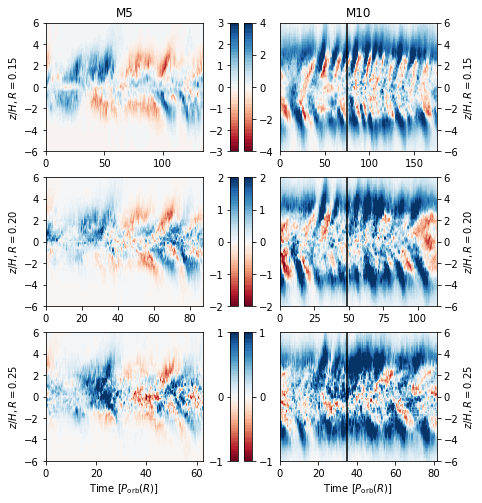

In [6]:

# PLOT 11: butterfly diagrams

from scipy.signal import convolve2d

radii_to_plot = [0.15, 0.20, 0.25]
bfield_unit = 1.0e-2

fig = plt.figure(figsize=[7,7])
gs = gridspec.GridSpec(3,6, width_ratios=[1,0.1,0.05,0.05,0.1,1], wspace=0.1)
cmap = 'RdBu'

suffix = ''# '_noAvg'

# ----------------------------------------------------------------

# MACH 5
mach_no = 5.
if suffix == '_noAvg':
    vscale = np.array([0.02, 0.015, 0.01]) / bfield_unit
else:
    vscale = np.array([0.03, 0.02, 0.01]) / bfield_unit
z_over_H_max = 6.0

# load and reuse
with open(dataset_pathstem[mach_no] + ('butterfly%s_Bcc3.pkl' % suffix), 'rb') as f:
    data = pkl.load(f)

for r_idx in range(len(radii_to_plot)):
    
    r = radii_to_plot[r_idx]

    porb_here = (2.*np.pi * np.sqrt(r**3/GM1)) / Porb
    times = list(data.val[r].keys())
    tmin, tmax = np.min(times), np.max(times)
    z_over_r = data.z_over_r
    z_over_H = z_over_r * mach_no

    x, y = np.meshgrid(times, z_over_H, indexing='ij')
    x = (np.array(x).flatten() / Porb - tstart_plot[mach_no]) / porb_here
    y = np.array(y).flatten()

    data_to_plot = []
    for t in times:
        data_to_plot.append(data.val[r][t])
        
    # fix numerical artifacts from AMR
    if suffix == '_noAvg':
        box = np.ones((3,32))/(3.*32.)
        data_to_plot = convolve2d(data_to_plot, box, mode='same', boundary='wrap')
    elif r == 0.15:
        box = np.ones((1,32))/32.
        data_to_plot = convolve2d(data_to_plot, box, mode='same', boundary='wrap')
        
    data_to_plot = np.array(data_to_plot).flatten() / bfield_unit

    mask = np.invert(np.isnan(data_to_plot))
    x, y, data_to_plot = x[mask], y[mask], data_to_plot[mask]
    
    # limit by min/max values, needed for the colorbar
    data_to_plot = np.where(data_to_plot > -vscale[r_idx], data_to_plot, -0.999*vscale[r_idx] * np.ones(data_to_plot.shape))
    data_to_plot = np.where(data_to_plot < vscale[r_idx], data_to_plot, 0.999*vscale[r_idx] * np.ones(data_to_plot.shape))

    # contour plot
    plt.subplot(gs[r_idx,0])
    plt.tricontourf(x, y, data_to_plot, vmin=-vscale[r_idx], vmax=vscale[r_idx], cmap=cmap, levels=50)
    plt.ylim(-z_over_H_max, z_over_H_max)
    
    # colorbar
    plt.subplot(gs[r_idx,2])
    cbar = plt.colorbar(cax=plt.gca(), ticks=[-3, -2, -1, 0, 1, 2, 3])
    plt.gca().yaxis.tick_left()

    plt.subplot(gs[r_idx,0])
    
    # plot a single orbital period at the given radius
    if False:
        porb_here = (2.*np.pi * np.sqrt(r**3/GM1)) / Porb
        tstart = (tmin + 0.05*(tmax-tmin)) / Porb - tstart_plot[mach_no]
        zz = -0.85 * z_over_H_max
        plt.plot([tstart, tstart + 10.*porb_here], [zz,zz], 'k-')

    # plot dt
    tstart = ((tmin + 0.05*(tmax-tmin)) / Porb - tstart_plot[mach_no]) / porb_here
    dt = (times[1]-times[0]) / (Porb*porb_here)
    zz = -0.85 * z_over_H_max
    plt.plot([tstart, tstart + dt], [zz,zz], 'k-')
    
    plt.ylabel('$z/H, R=%.2f$' % r)
    
    print(dt/porb_here)

# ----------------------------------------------------------------

# MACH 10
mach_no = 10.
if suffix == '_noAvg':
    vscale = np.array([0.04, 0.02, 0.01]) / bfield_unit
else:
    vscale = np.array([0.04, 0.02, 0.01]) / bfield_unit
z_over_H_max = 6.0

# load and reuse
with open(dataset_pathstem[mach_no] + ('butterfly%s_Bcc3.pkl' % suffix), 'rb') as f:
    data = pkl.load(f)

for r_idx in range(len(radii_to_plot)):
    
    r = radii_to_plot[r_idx]

    porb_here = (2.*np.pi * np.sqrt(r**3/GM1)) / Porb
    times = list(data.val[r].keys())
    tmin, tmax = np.min(times), np.max(times)
    z_over_r = data.z_over_r
    z_over_H = z_over_r * mach_no

    x, y = np.meshgrid(times, z_over_H, indexing='ij')
    x = (np.array(x).flatten() / Porb - tstart_plot[mach_no]) / porb_here
    y = np.array(y).flatten()

    data_to_plot = []
    for t in times:
        data_to_plot.append(data.val[r][t])
        
    if suffix == '_noAvg':
        box = np.ones((3,32))/(3.*32.)
        data_to_plot = convolve2d(data_to_plot, box, mode='same', boundary='wrap')
        
    data_to_plot = np.array(data_to_plot).flatten() / bfield_unit

    mask = np.invert(np.isnan(data_to_plot))
    x, y, data_to_plot = x[mask], y[mask], data_to_plot[mask]
    
    # limit by min/max values, needed for the colorbar
    data_to_plot = np.where(data_to_plot > -vscale[r_idx], data_to_plot, -0.999*vscale[r_idx] * np.ones(data_to_plot.shape))
    data_to_plot = np.where(data_to_plot < vscale[r_idx], data_to_plot, 0.999*vscale[r_idx] * np.ones(data_to_plot.shape))

    # contour plot
    plt.subplot(gs[r_idx,5])
    plt.tricontourf(x, y, data_to_plot, vmin=-vscale[r_idx], vmax=vscale[r_idx], cmap=cmap, levels=50)
    plt.ylim(-z_over_H_max, z_over_H_max)
    
    # colorbar
    if r_idx > 0:
        ticks=[-4, -2, -1, 0, 1, 2, 4]
        if suffix == '_noAvg':
            ticks = [-8, -6, -4, -2, 0, 2, 4, 6, 8]
    else:
        ticks=[-4, -2, 0, 2, 4]
        if suffix == '_noAvg':
            ticks = [-12, -8, -4, 0, 4, 8, 12]
    
    plt.subplot(gs[r_idx,3])
    cbar = plt.colorbar(cax=plt.gca(), ticks=ticks)

    plt.subplot(gs[r_idx,5])
    
    # plot a single orbital period at the given radius
    if False:
        porb_here = (2.*np.pi * np.sqrt(r**3/GM1)) / Porb
        tstart = 0.05*(tmax - tstart_plot[mach_no]*Porb) / Porb
        zz = -0.85 * z_over_H_max
        plt.plot([tstart, tstart + 10.*porb_here], [zz,zz], 'k-')

    # plot dt
    tstart = 0.05*(tmax - tstart_plot[mach_no]*Porb) / (Porb*porb_here)
    dt = (times[1]-times[0]) / (Porb*porb_here)
    zz = -0.85 * z_over_H_max
    plt.plot([tstart, tstart + dt], [zz,zz], 'k-')
    
    # plot the acc. config. boundary
    plt.axvline((accretion_state_times[mach_no]['A'][1] - tstart_plot[mach_no])/porb_here, color='k', ls='-')
    
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.ylabel('$z/H, R=%.2f$' % r)
    
    plt.xlim(0., None)
    
    print(dt/porb_here)
    
plt.subplot(gs[0,0])
plt.title('M5')
plt.subplot(gs[0,5])
plt.title('M10')
plt.subplot(gs[2,0])
plt.xlabel('Time [$P_{\\rm orb}(R)$]')
plt.subplot(gs[2,5])
plt.xlabel('Time [$P_{\\rm orb}(R)$]')
    
plt.subplots_adjust(bottom=0.07, top=0.94)

#plt.tight_layout()
if save:
    plt.savefig(output_path + ('butterfly%s.png' % suffix), format='png', dpi=dpi)
else:
    plt.show()
plt.close()

In [ ]:

# PLOT 12: Doppler diagrams

plt.rcParams.update({'font.size': 7})
cmap = cm.hot

fig = plt.figure(figsize=[3.5,2.])
gs = gridspec.GridSpec(1,2, wspace=0.1)

# ----------------------------------------------------------
# MACH 5
mach_no = 5

plt.subplot(gs[0,0])
ax0 = plt.gca()

with open(dataset_pathstem[mach_no] + 'doppler.pkl', 'rb') as f:
    vx, vy, doppler = pkl.load(f)

vmin, vmax = np.log10(np.exp(-12.)), -2.792
    
ctp = plt.contourf(vx, vy, np.log10(doppler), levels=500, cmap=cmap, vmin=vmin, vmax=vmax)
plt.gca().add_artist(plt.Circle((0,0), np.sqrt(GM1/0.05), color='w', ls='--', fill=False))
plt.gca().add_artist(plt.Circle((0,0), np.sqrt(GM1/0.175), color='w', ls='--', fill=False))
plt.gca().add_artist(plt.Circle((0,0), 0.5, color='white', fill=True))
plt.gca().set_aspect('equal')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.xlabel('$v_x$ [sim.u.]')
plt.ylabel('$v_y$ [sim.u.]')
plt.text(2.5, 3., 'M5', bbox=dict(boxstyle="square", ec=(0.,0.,0.), fc=(1., 1.,1.)))

plt.subplots_adjust(left=0.14, right=0.86)

ax = fig.add_axes([ax0.get_position().x0, ax0.get_position().y1+0.015, ax0.get_position().x1-ax0.get_position().x0, 0.025])
ticks = np.array([-3., -2., -1., 0.])
cbar = ColorbarBase(ax, norm=Normalize(vmin=(vmax+ticks[0]), vmax=vmax), cmap=cmap, orientation='horizontal', ticks=(ticks+vmax))
#cbar = plt.colorbar(ctp, cax=ax, ticks=(vmax+ticks))
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.set_xticklabels([('$10^{%i}$' % tick if tick != 0 else 1) for tick in ticks])

# ----------------------------------------------------------
# MACH 10
mach_no = 10

plt.subplot(gs[0,1])

with open(dataset_pathstem[mach_no] + 'doppler.pkl', 'rb') as f:
    vx, vy, doppler = pkl.load(f)
    
vmin, vmax = -6.,-3.68

ctp = plt.contourf(vx, vy, np.log10(doppler), levels=500, cmap=cmap, vmin=vmin, vmax=vmax)
plt.gca().add_artist(plt.Circle((0,0), np.sqrt(GM1/0.05), color='w', ls='--', fill=False))
plt.gca().add_artist(plt.Circle((0,0), np.sqrt(GM1/0.175), color='w', ls='--', fill=False))
plt.gca().add_artist(plt.Circle((0,0), 0.5, color='white', fill=True))
plt.gca().set_aspect('equal')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.xlabel('$v_x$ [sim.u.]')
plt.ylabel('$v_y$ [sim.u.]')
plt.text(-3.5, 3., 'M10', bbox=dict(boxstyle="square", ec=(0.,0.,0.), fc=(1., 1.,1.)))

ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax = fig.add_axes([ax.get_position().x0, ax.get_position().y1+0.015, ax.get_position().x1-ax.get_position().x0, 0.025])
ticks = np.array([-2., -1., 0.])
cbar = ColorbarBase(ax, norm=Normalize(vmin=(vmax+ticks[0]-0.3), vmax=vmax), cmap=cmap, orientation='horizontal', ticks=(ticks+vmax))
#cbar = plt.colorbar(ctp, cax=ax, ticks=(vmax+ticks))
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.set_xticklabels([('$10^{%i}$' % tick if tick != 0 else 1) for tick in ticks])

# ----------------------------------------------------------

if True:# save:
    plt.savefig(output_path + 'doppler.png', format='png', dpi=dpi)
else:
    plt.show()
plt.close()